In [1]:
%load_ext autoreload
%autoreload 2
from fun import *

In [2]:
db_filename = '/home/msarrias/dbs/homo_1.db'
db = gffutils.FeatureDB(db_filename, keep_order=True)

### We will investigate the question of can tools detect exon duplications? 

We will evaluate:

* [exonerate](https://www.ebi.ac.uk/about/vertebrate-genomics/software/exonerate-manual)
* [gmap](http://research-pub.gene.com/gmap/src/README)
* [spaln2](https://github.com/ogotoh/spaln)



##### I. We align the proteins on the chromosome sequence without mutations

In [3]:
# !exonerate genes_with_dup_original_prot_seq_.fa /home/msarrias/data/Homo_sapiens.GRCh38.dna.chromosome.1.fa --model protein2genome --showtargetgff True > Exonerate/exon_showgff_protein2genome.out.txt 

In [4]:
with open('../files/simulated_genes_breakdown_dict.pkl', 'rb') as handle:
    simulated_genes_breakdown_dict_before = pickle.load(handle)
with open('../files/protein_gene_corresp.pkl', 'rb') as handle:
    protein_gene_dict = pickle.load(handle)
with open('../files/GRCh38_duplicated_coding_exons_coords.pkl', 'rb') as handle:
    dups_GRCh38_gene_coords = pickle.load(handle)

In [5]:
#parse exonerate output

ex_out_fname = 'Exonerate/exon_showgff_protein2genome.out.txt'
ex_format = 'exonerate-text'

genes_with_duplications = list(protein_gene_dict.values())
genes_location = {gene_id: P.open(db[gene_id].start,db[gene_id].end) for gene_id in genes_with_duplications}

all_qresult = list(SearchIO.parse(ex_out_fname, ex_format))
hits_feature_intervals = parse_exonerate_output(all_qresult)
overlaping_queries = get_overlaping_queries(protein_gene_dict, genes_location, hits_feature_intervals)

### We will now work with a chromosome containing coding exons duplications

In [6]:
fasta_GRCh38_seq = SeqIO.parse(open('/home/msarrias/data/Homo_sapiens.GRCh38.dna.chromosome.1.fa'),'fasta')
fasta_GRCh38_seq = { fasta.id : {'+' : str(fasta.seq),
                                 '-': str(fasta.seq.reverse_complement())} for fasta in fasta_GRCh38_seq}

fasta_GRCh38_seq_with_dup = SeqIO.parse(open('GRCh38_with_coding_exon_dup.fa'),'fasta')
fasta_GRCh38_seq_with_dup = { fasta.id : str(fasta.seq) for fasta in fasta_GRCh38_seq_with_dup}


##### b.  Duplications of the second coding exon inserted before the real coding exon

In [7]:
# !exonerate genes_with_dup_original_prot_seq_.fa GRCh38_with_coding_exon_dup.fa --model protein2genome --showtargetgff True > Exonerate/exon_showgff_protein2genome_ce_dup.out.txt 

In [8]:
#parse exonerate output
ex_out_fname = 'Exonerate/exon_showgff_protein2genome_ce_dup.out.txt'
all_qresult = list(SearchIO.parse(ex_out_fname, ex_format))

In [9]:
hits_2nd_ced_before = parse_exonerate_output(all_qresult)
dups_genes_loc_before  = {gene_id: P.open(value['seq'][0][0], value['seq'][0][1]) 
                          for gene_id, value in dups_GRCh38_gene_coords.items()}
overlaping_queries_before = get_overlaping_queries(protein_gene_dict, dups_genes_loc_before,  hits_2nd_ced_before)
sorted_overlaping_queries_before = {i : copy.deepcopy(overlaping_queries_before[i]) 
                                    for i in overlaping_queries.keys()} 

duplication


##### c.  Duplications of the second coding exon inserted after the real coding exon

In [10]:
# !exonerate genes_with_dup_original_prot_seq_after.fa GRCh38_with_coding_exon_dup_after.fa --model protein2genome --showtargetgff True > Exonerate/exon_showgff_protein2genome_ce_dup_after.out.txt 

In [11]:
with open('../files/GRCh38_duplicated_coding_exons_after_coords.pkl', 'rb') as handle:
    dups_GRCh38_gene_coords_after = pickle.load(handle)

with open('../files/simulated_genes_breakdown_dict_after.pkl', 'rb') as handle:
    simulated_genes_breakdown_dict_after = pickle.load(handle)    

In [12]:
fasta_GRCh38_seq_with_dup_after = SeqIO.parse(open('GRCh38_with_coding_exon_dup_after.fa'),'fasta')
fasta_GRCh38_seq_with_dup_after = { fasta.id : str(fasta.seq) for fasta in fasta_GRCh38_seq_with_dup_after}

In [13]:
#parse exonerate output
ex_out_fname = 'Exonerate/exon_showgff_protein2genome_ce_dup_after.out.txt'
all_qresult = list(SearchIO.parse(ex_out_fname, ex_format))

In [14]:
hits_feature_intervals_2nd_ced_after = parse_exonerate_output(all_qresult)
dups_genes_loc_after  = {gene_id: P.open(value['seq'][0][0], value['seq'][0][1]) 
                         for gene_id, value in dups_GRCh38_gene_coords_after.items()}
overlaping_queries_after = get_overlaping_queries(protein_gene_dict, dups_genes_loc_after, 
                                                  hits_feature_intervals_2nd_ced_after)

sorted_overlaping_queries_after = {i : copy.deepcopy(overlaping_queries_after[i]) 
                                   for i in overlaping_queries.keys()} 

duplication


### 1. Exonerate alignments:

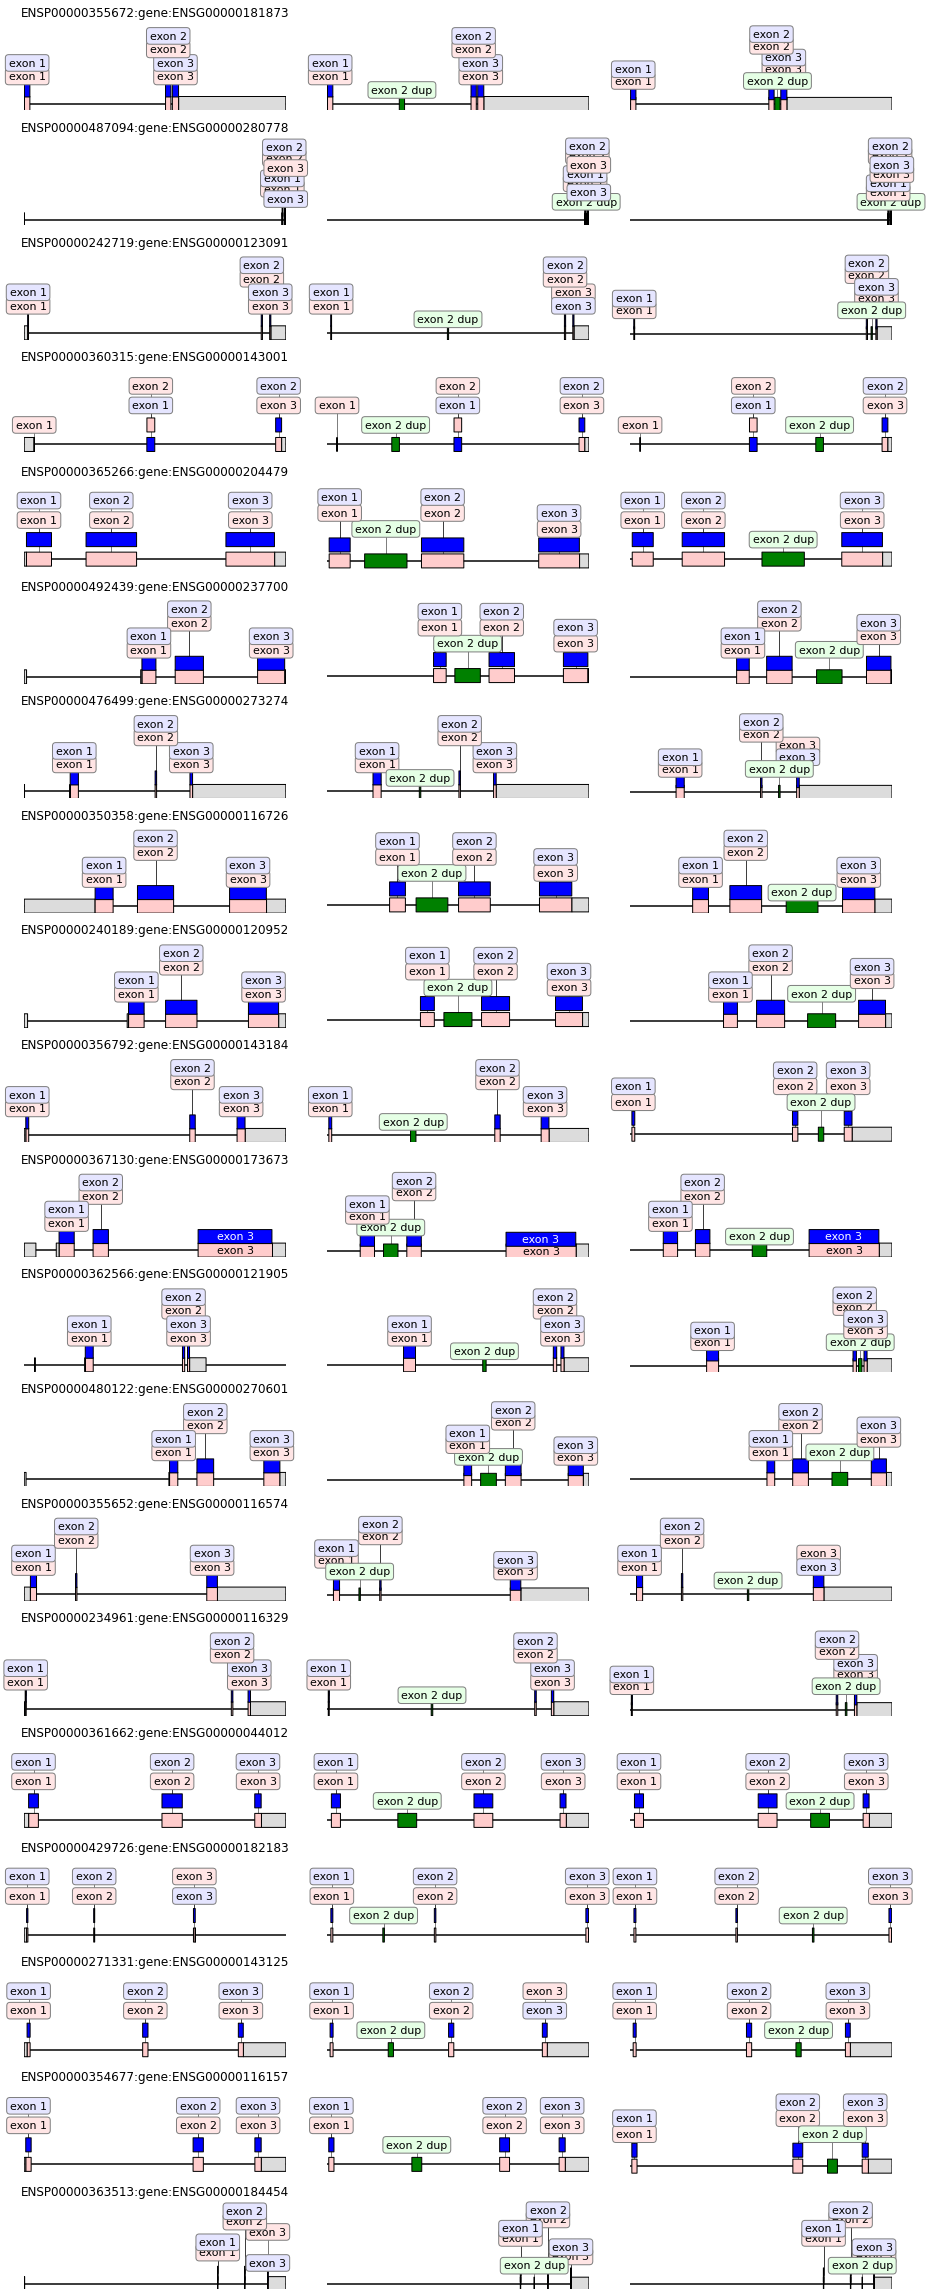

In [15]:
fig, ax = plt.subplots(len(overlaping_queries),3, figsize=(13, 32))
plt.tight_layout()
for prot_idx, (prot_id, overlaping_hit_dict) in enumerate(overlaping_queries.items()):
    gene_id = protein_gene_dict[prot_id]
    coords_gene = genes_location[gene_id]
    gs, ge = coords_gene.lower, coords_gene.upper
    features = []
    idx = 1
    record = get_record(idx, gene_id, dups_GRCh38_gene_coords, gs, ge, 
                        simulated_genes_breakdown_dict_before[gene_id],
                        overlaping_hit_dict)
    ax[prot_idx,0].set_title(prot_id + ':' + gene_id, loc='center')
    record.plot(ax=ax[prot_idx,0], figure_width=5, with_ruler=False) 
for prot_idx, (prot_id, overlaping_hit_dict) in enumerate(sorted_overlaping_queries_before.items()):
    gene_id = protein_gene_dict[prot_id]
    coords_gene = dups_genes_loc_before[gene_id]
    gs, ge = coords_gene.lower, coords_gene.upper
    features = []
    idx = 1
    record = get_record(idx, gene_id, dups_GRCh38_gene_coords, gs, ge, 
                        simulated_genes_breakdown_dict_before[gene_id],
                        overlaping_hit_dict, mutations=True,
                        genome_seq = fasta_GRCh38_seq['1']['+'],
                        mut_loc='before', exon_dup=2, 
                        genome_seq_with_mut=fasta_GRCh38_seq_with_dup['GRCh38_with_coding_exon_dup'])
    record.plot(ax=ax[prot_idx,1], figure_width=5, with_ruler=False)
for prot_idx, (prot_id, overlaping_hit_dict) in enumerate(sorted_overlaping_queries_after.items()):
    gene_id = protein_gene_dict[prot_id]
    coords_gene = dups_genes_loc_after[gene_id]
    gs, ge = coords_gene.lower, coords_gene.upper
    features = []
    idx = 1
    record = get_record(idx, gene_id, dups_GRCh38_gene_coords_after, gs, ge,
                        simulated_genes_breakdown_dict_after[gene_id],
                        overlaping_hit_dict, mutations=True,
                        genome_seq = fasta_GRCh38_seq['1']['+'],
                        mut_loc='after', exon_dup=2, 
                        genome_seq_with_mut=fasta_GRCh38_seq_with_dup_after['GRCh38_with_coding_exon_dup'])
    record.plot(ax=ax[prot_idx,2], figure_width=5, with_ruler=False)
fig.tight_layout()    
plt.savefig('Figures/exonerate_alignms.jpg', bbox_inches='tight') 

##### Will exonerate find the two possible alignments in the same region where the duplication is, or does it require the alignments to hit different parts of the genome sequence?


In [ ]:
# !exonerate genes_with_dup_original_prot_seq.fa GRCh38_with_exon_dup.fa --model protein2genome --bestn 2 --showtargetgff True > exonerate_bestn_2_showgff_protein2genome.out.txt

### gmap

In [ ]:
# !gmap -g GRCh38_with_exon_dup.fa -A genes_with_dup_original_prot_seq.fa > gmap.out.txt

In [ ]:
# !cat gmap.out.txt

### spaln

In [ ]:
# !spaln -S 1 GRCh38_with_exon_dup.fa genes_with_dup_original_prot_seq.fa > spaln.out.txt